## Features Comparison Notebook

---

### Objective:

- To assess the impact of different features on the performance of the model.
- To determine the optimal features for the model.

### Methodology:

- A model (RF, SVM, LR) is trained with different features (Chroma, MFCC_30, MFCC_120, CQT_30, CQT_70). The features are used 'as extracted' without any additional processing.
- The model is trained with 80% of the data and tested with the remaining 20%.
- The metric used to evaluate the model is the macro F1 score. Because the accuracy is not a good metric for imbalanced datasets, since it can be high even if the model is not performing well on the minority class. The F1 score is the harmonic mean of precision and recall, and it is a better metric for imbalanced datasets.
  In addition, the macro F1 score is the average of the F1 score of each class, and it consider all classes equally, which is important in this case since the dataset is imbalanced.

#### Findings:

All types of features are highly predictive

| Type                | N° Features |
| ------------------- | ----------- |
| MFCC                | 30          |
| CQT                 | 70          |
| Chroma              | 12          |
| RMS                 | 40          |
| Zero Crossing Rates | 40          |
| Spectral Centroid   | 40          |
| Spectral Bandwidth  | 60          |
| Spectral Rolloff    | 40          |


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, recall_score

from sklearn.svm import SVC
import tqdm.notebook as tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(style="whitegrid")



In [64]:
# set the paths
BASE_DIR = "../../dataset/"
LABELS = BASE_DIR + "labels.csv"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 2

RESULT_NAME = "results_features_comparison.csv"
COMPLETE_DATASET = "full_data_1s_4000hz_30mfcc_70cqt_12chroma.npy"

In [ ]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
num_feats = {
    "30 MFCC": "30mfcc",
    "60 MFCC": "60mfcc",
    "90 MFCC": "90mfcc",
    "120 MFCC": "120mfcc",
    "12 Chroma": "12chroma",
    "20 CQT": "20cqt",
    "30 CQT": "30cqt",
    "40 CQT": "40cqt",
    "60 CQT": "60cqt",
    "70 CQT": "70cqt",
    "20 RMS": "21rms",
    "40 RMS": "41rms",
    "60 RMS": "61rms",
    "20 ZCR": "21zcr",
    "40 ZCR": "41zcr",
    "60 ZCR": "61zcr",
    "20 SC": "21sc",
    "40 SC": "41sc",
    "60 SC": "61sc",
    "20 SB": "21sb",
    "40 SB": "41sb",
    "60 SB": "61sb",
    "20 SR": "21sr",
    "40 SR": "41sr",
    "60 SR": "61sr",
}


# ----------------------------------------- Create DataFrame to store results-----------------------------------------

result_df_f1 = pd.DataFrame(
    columns=num_feats.keys(),
    index=["Random Forest", "SVM", "Logistic Regression"],
)
# ----------------------------------------- Loop over each feature-----------------------------------------
for name, num_feat in num_feats.items():
    print(f"Processing 4000hz_{num_feat}\n")

    # Load the data
    FEATURES_NAME = f"full_data_{interval}s_4000hz_{num_feat}.npy"
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    # Extract data from the dictionary
    data_list = []
    for key in full_data_dict_keys:
        X = full_data[key]["X"]
        y = full_data[key]["y"]
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data_list.append(data)
    full_data_array = np.concatenate(data_list, axis=0)

    # Split the data into train and test
    X = full_data_array[:, :-1]
    y = full_data_array[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )

    # Train and evaluate models: Random Forest, SVM, Logistic Regression
    for model_name, clf in {
        "Random Forest": RandomForestClassifier(random_state=SEED),
        "SVM": SVC(random_state=SEED),
        "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000),
    }.items():
        print(f"Training {model_name}\n")
        clf.fit(X_train, y_train)
        precision = precision_score(y_test, clf.predict(X_test), average="macro")
        f1 = f1_score(y_test, clf.predict(X_test), average="macro")
        recall=recall_score(y_test, clf.predict(X_test), average="macro")
        score = clf.score(X_test, y_test)
        result_df_f1.loc[model_name, name] = f1
# ----------------------------------------- Save the results-----------------------------------------
result_df_f1.to_csv(MODELS_RESULTS + "results_features_comparison.csv")

## Evaluate the acuracy of the model with different features

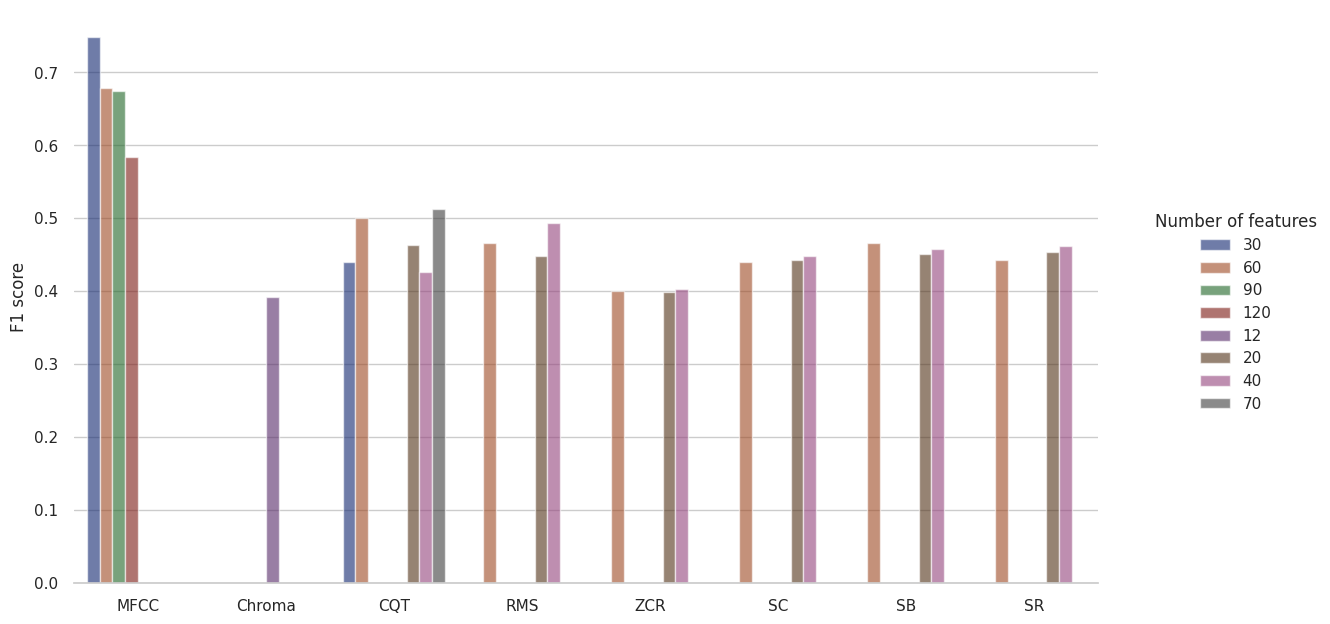

In [90]:
result_df = pd.read_csv(MODELS_RESULTS + "results_features_comparison.csv", index_col=0)

analysis_df = pd.DataFrame(result_df.loc["Random Forest"])

analysis_df.reset_index(inplace=True)
analysis_df[["Number", "Type"]] = analysis_df["index"].str.split(" ", expand=True)
analysis_df.drop(columns=["index"], inplace=True)


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=analysis_df,
    kind="bar",
    x="Type",
    y="Random Forest",
    hue="Number",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
)
g.despine(left=True)
g.figure.set_size_inches(15, 7)
g.despine(left=True)
g.set_axis_labels("", "F1 score")
g.legend.set_title("Number of features")
